# Transport network density

## Introduction

This notebook is based on the [eu_grid_population.py](https://github.com/GISAdamToth/characteristics_of_transport_network_toolbox/blob/main/python_scripts/eu_grid_population.py) script, which is part of the [Calculation possibilies of transport network's characteristics of countries and cities](https://www.geoinformatics.upol.cz/dprace/bakalarske/toth22/) bachelor thesis by Adam Tóth (2022).

In this notebook you will calculate the transport network density in two ways:
1) "classic" approach, where density = length / area
2) "demographic" approach, where density = length / population

You'll need a cloned ArcGIS Python environment so you can run [**ArcPy**](https://pro.arcgis.com/en/pro-app/3.1/arcpy/get-started/what-is-arcpy-.htm) functions and install additional packages.

The workflow is divided into the following sections:
- [ArcGIS setup](#arcgis)
- [Transport network data](#osmnx)
- [Population data](#popgrid)
- [Hexagonal grid](#hex)
- [Density calculation](#calc)
- [Visualization](#vis)

## ArcGIS setup <a id="arcgis"></a>

Start ArcGIS Pro and create a new project.

Import **ArcPy** and allow overwriting outputs with the same name.

In [8]:
import arcpy
arcpy.env.overwriteOutput = True

Save the path to your project's geodatabase and set it as the workspace.

In [9]:
workspace_dir = "C:/Users/petre/OneDrive/Plocha/MGR/1LS/PRODA/randomcvikooo/"
workspace_gdb = "C:/Users/petre/OneDrive/Plocha/MGR/1LS/PRODA/randomcvikooo/randomcvikooo.gdb/"
arcpy.env.workspace = workspace_gdb

## Transport network data <a id="osmnx"></a>

Transport network is a term which covers all parts of the transport infrastructure in a certain area, typically country, region or city. Transport network therefore includes roads, railways, airports, river and sea ports (harbours), pipelines, all kinds of junctions, terminals and so on. This notebook focuses on the line features of transport network, because the density is expressed as **length** either per area or per capita. 

Therefore you can use any kind of line layer representing highways, streets, railways for example. In this part you'll go through the process of accessing railways data from OpenStreetMap (OSM) and getting them ready for further work in ArcGIS Pro.

This part is inspired by the notebook [Accessing OSM Data in Python](https://pygis.io/docs/d_access_osm.html) published at PyGIS.

You'll need [**OSMnx**](https://osmnx.readthedocs.io/en/stable/) and [**GeoPandas**](https://geopandas.org/en/stable/) packages. There are various ways how to install them into your cloned ArcGIS Python environment, one simple way is to uncomment and execute the next two code lines.

In [10]:
 %pip install osmnx
 %pip install geopandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Import the packages now.

In [14]:
import osmnx as ox
import geopandas as gpd

### Area of interest

The first step is to choose the area of interest. You can choose any European city, region or country. For this notebook the area of interest will be the Liverpool city in the UK.

In [15]:
place_name = "Liverpool, UK"

Using the functionality of imported packages, save the area of interest as a GeoDataFrame into the variable ```area``` and check how is looks like.

In [16]:
area = ox.geocode_to_gdf(place_name)
area

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"POLYGON ((-3.01917 53.43616, -3.01806 53.43323...",53.474989,53.311543,-2.818,-3.019173,250026126,relation,172987,53.407199,-2.99168,boundary,administrative,16,0.670751,city,Liverpool,"Liverpool, Liverpool City Region, England, Uni..."


You can also verify its data type and plot it using [**matplotlib**](https://matplotlib.org/) built-in the **GeoPandas** package.

In [ ]:
print(type(area))
area.plot()

Save now this polygon GeoDataFrame into a geojson file.

In [ ]:
area.to_file(workspace_dir + 'liverpool_boundary.geojson', driver='GeoJSON')
area = 'liverpool_boundary'

Import the geojson file with area of interest into your geodatabase.

In [ ]:
arcpy.conversion.JSONToFeatures(workspace_dir + 'liverpool_boundary.geojson', area, "POLYGON")

### OSM data

Let's now get to the OSM railway data. OSM data is divided into multiple categories and these are divided into several subcategories. You can choose which category you are interested in by specifying its name from the list of [OSM tags](https://wiki.openstreetmap.org/wiki/Map_features).

If you want to get to all subcategories of the chosen category, type ```True```.

Now get all kinds of railways in Liverpool into the GeoDataFrame ```railways```.

In [ ]:
# get all types of railways (https://wiki.openstreetmap.org/wiki/Map_features#Railway)
tags = {'railway': True}  
# get only rails = "Full sized passenger or freight train tracks in the standard gauge for the country or state." 
#tags = {'railway': 'rail'}  

railways = ox.features_from_place(place_name, tags)
railways.head()

Print the number of railways in the GeoDataFrame and plot a simple map scheme of them.

In [ ]:
print(len(railways))
railways.plot()

Keep only the geometry attribute of the railways because that's what interests you.

In [ ]:
railways = railways.loc[:,railways.columns.str.contains('addr:|geometry')]

And select only those rows that are of a LineString geometry type. Then print the number of these rails and plot them.

In [ ]:
rails = railways.loc[railways.geometry.type=='LineString']
print(len(rails))
rails.plot()

Save this rails GeoDataFrame into a geojson file.

In [ ]:
rails.to_file(workspace_dir + 'liverpool_rails.geojson', driver='GeoJSON')
rails = 'liverpool_rails'

Import the geojson file with rails into your geodatabase.

In [ ]:
arcpy.conversion.JSONToFeatures(workspace_dir + 'liverpool_rails.geojson', rails, "POLYLINE")

## Population data <a id="popgrid"></a>

In this part you'll download GEOSTAT 1 $km^2$ population grid. It is a population dataset provided by Eurostat which covers the most of Europe. It consists of 1 $km^2$ squares and each square contains the number of inhabitants who live inside the square area.

Install necessary libraries.

In [ ]:
# %pip install os
# %pip install requests
# %pip install zipfile

Import them.

In [ ]:
import os
import requests
import zipfile

Set parameters and variables for downloading zipped population grid from the eurostat website.

In [ ]:
# URL of the population grid to download
url = "https://ec.europa.eu/eurostat/cache/GISCO/geodatafiles/JRC_GRID_2018.zip"

# Define the file name and path for saving the downloaded file
file_name = "JRC_GRID_2018.zip"
file_path = os.path.join(workspace_dir, file_name)  # Save in the workspace directory

Send a GET request to the URL to download the file

In [ ]:
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Write the content to a file
    with open(file_path, 'wb') as f:
        f.write(response.content)
    print(f"File '{file_name}' downloaded successfully!")
else:
    print("Failed to download the file.")

Extract (unzip) the downloaded file.

In [ ]:
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(file_path[:-4] + '/')

Save the path to the extracted population grid shapefile itself.

In [ ]:
pop_data = file_path[:-4] + '/JRC_POPULATION_2018.shp'
pop_data

### Population grid editing

Now you need to clip the population grid by your area of interest. This step is not that simple as it looks, because some of the grid's squares or "pixels" will be cut during clipping, so they will became smaller. But the number of inhabitants will remain the same. Therefore the population inside of the pixels is recalculated proportionally to the actual pixel size.

First select the population grid "pixels" that intersect with the area of interest. Copy or export these "pixels" into your workspace and then don't forget to clear the selection.

In [ ]:
area_selection = arcpy.management.SelectLayerByLocation(pop_data, "INTERSECT", area)
arcpy.management.CopyFeatures(area_selection, "pop_data_liverpool")
area_selection = arcpy.management.SelectLayerByAttribute(pop_data, "CLEAR_SELECTION")

Save the "pixel" area size in a new field which will be named ```"area_orig"```. You will make a copy of the ```"Shape_Area"``` field basically.

In [ ]:
arcpy.management.AddField("pop_data_liverpool", "area_orig", "DOUBLE")
arcpy.management.CalculateField("pop_data_liverpool", "area_orig", '!Shape_Area!')

Clip the copied/exported population grid "pixels" by the area of interest.

In [ ]:
arcpy.analysis.Clip("pop_data_liverpool", area, "clipped_pop_data")
pop_data = "clipped_pop_data"

Add a new field named ```"P_2018_orig"``` and recalculate into it the population in the clipped "pixels" proportionally to their area size.

In [ ]:
arcpy.management.AddField(pop_data, "P_2018_orig", "DOUBLE")
arcpy.management.CalculateField(pop_data, "P_2018_orig", '(!TOT_P_2018!/!area_orig!)*!Shape_Area!')

## Hexagonal grid <a id="hex"></a>

Generate a hexagonal grid of hexagon size 2 $km^2$ over the area of interest and then clip it by its polygon layer. The density will be calculated for each hexagon.

In [ ]:
size = "2 SquareKilometers"
arcpy.management.GenerateTessellation("hex_grid", area, "HEXAGON", size)
arcpy.analysis.Clip("hex_grid", area, "hex_gr")

Now you'll do the same population recalculation as you did during clipping, but now the "pixels" will be intersected and dissolved. Here is an illustration of the population recalculation.

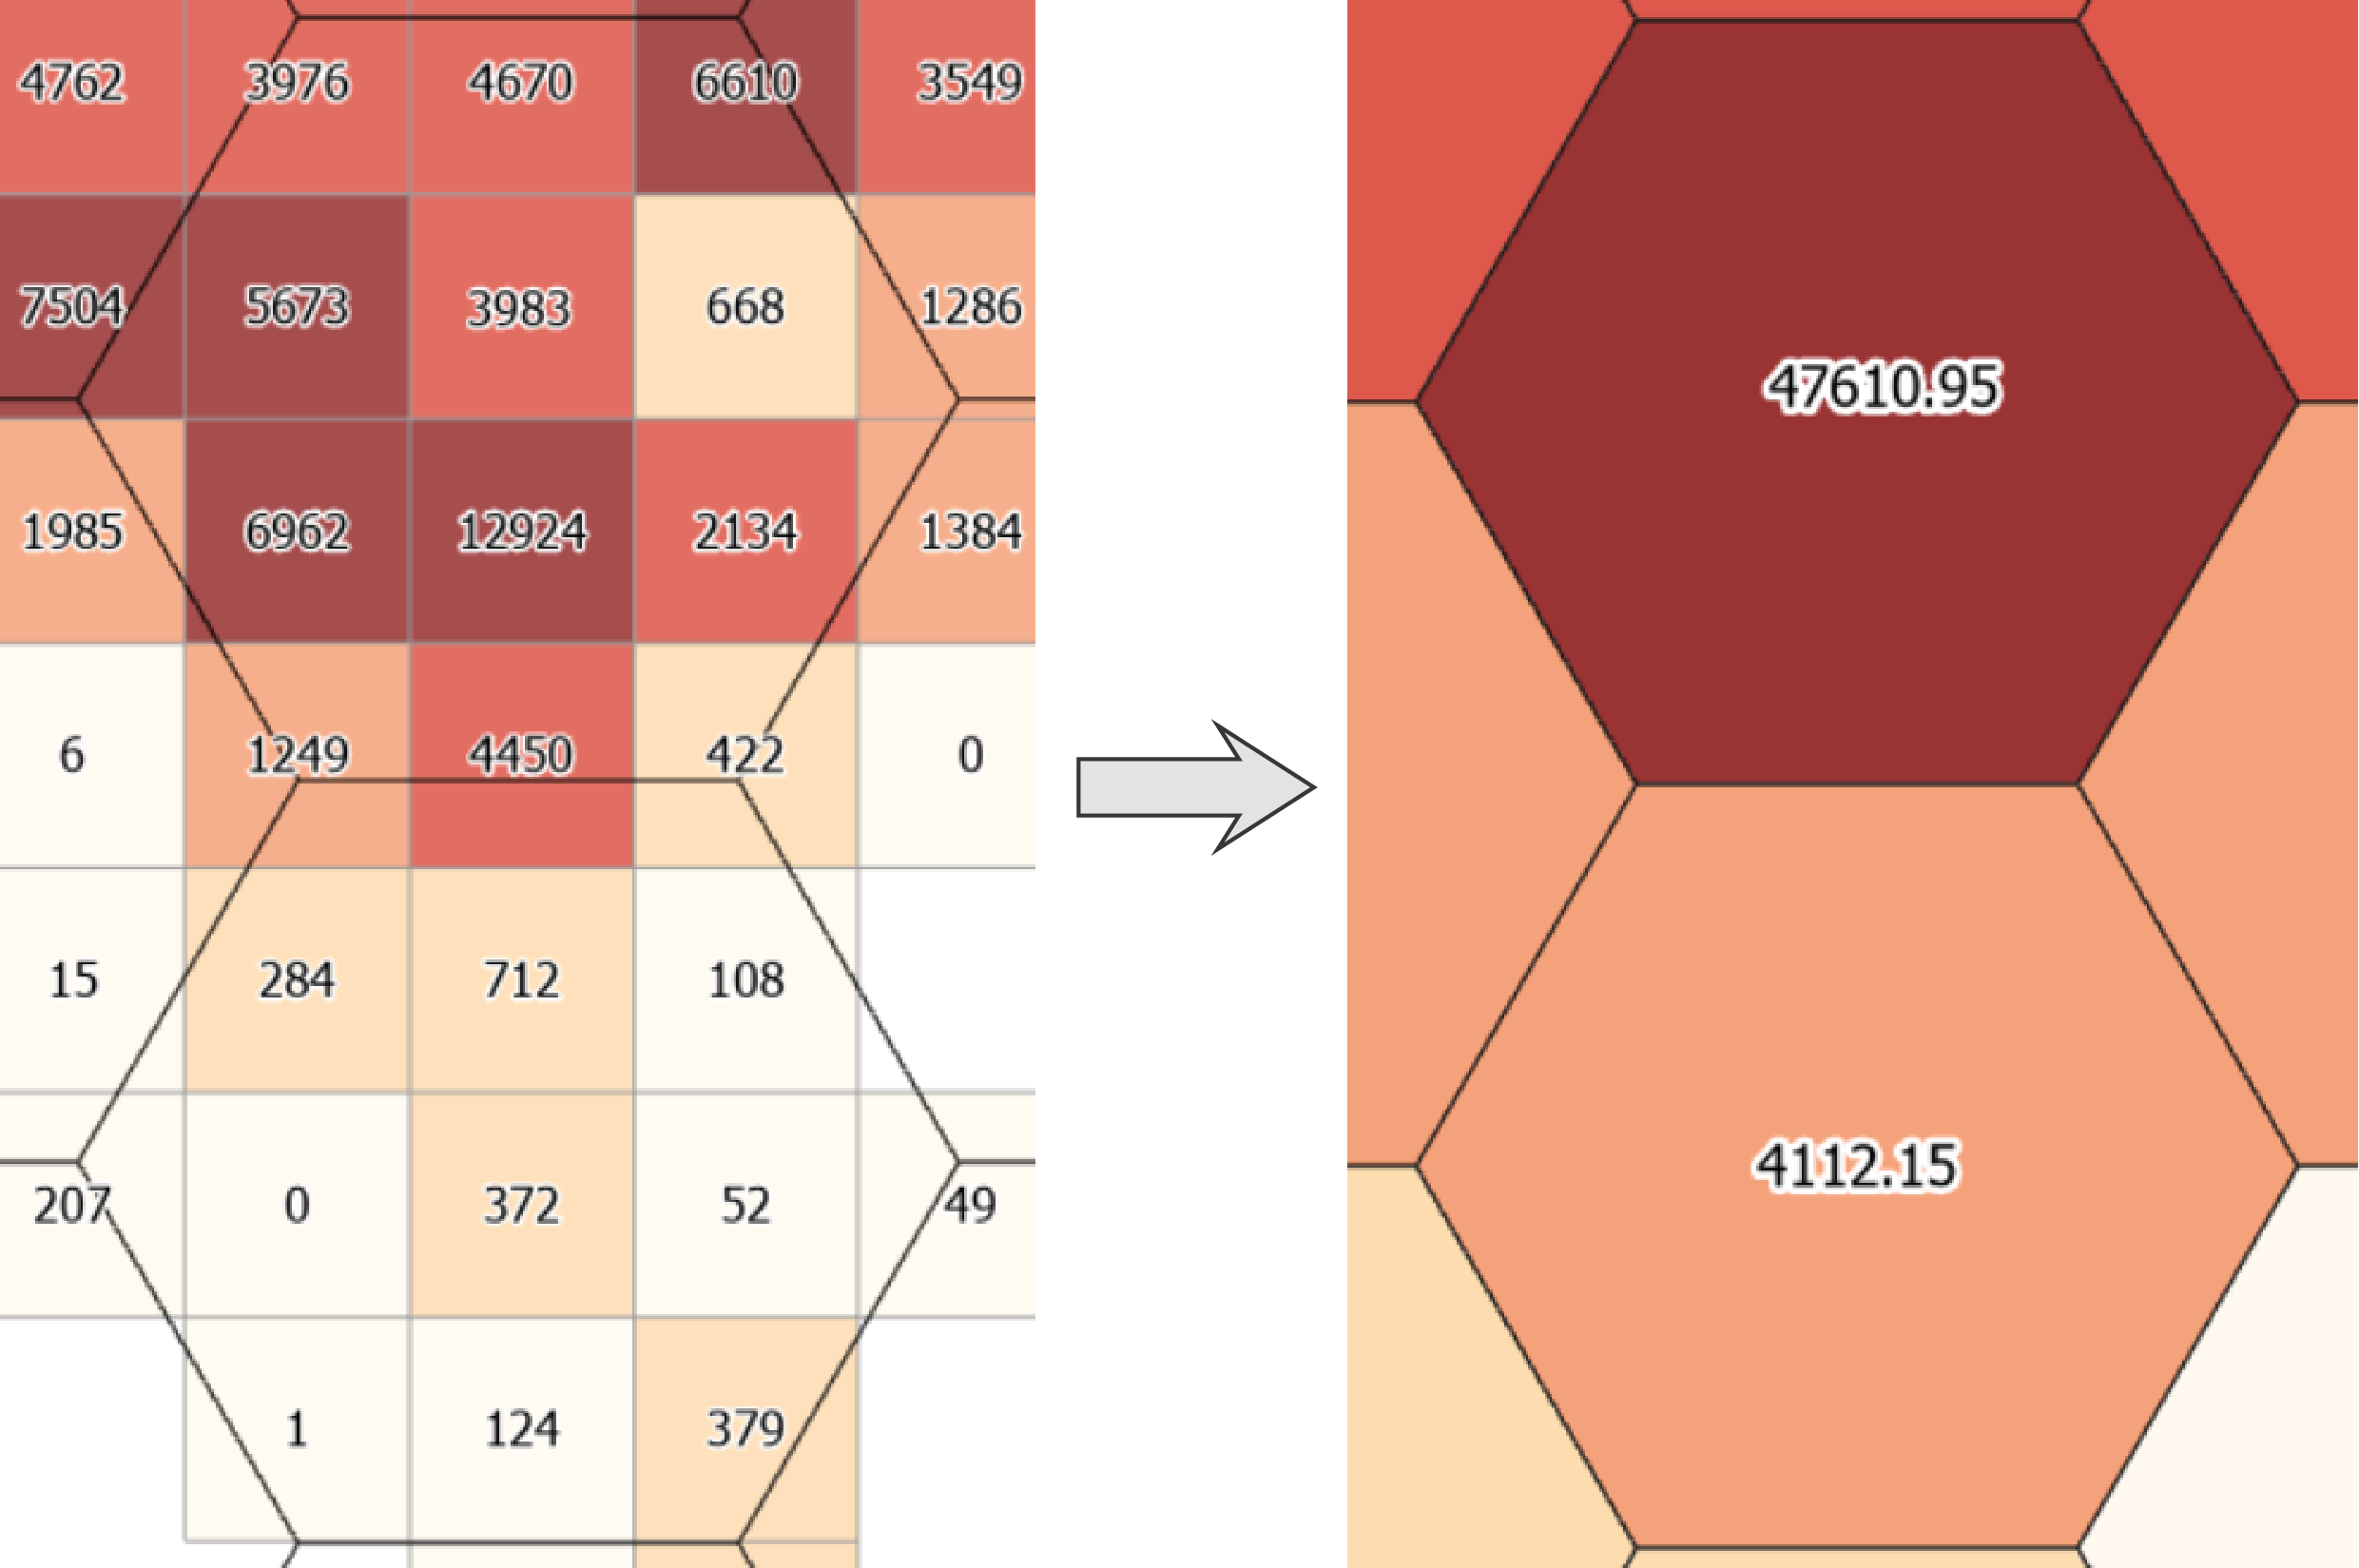

Field ```"area_orig"``` will contain the area size of current clipped "pixels".

In [ ]:
arcpy.management.CalculateField(pop_data, "area_orig", '!Shape_Area!')

Now you'll get the population information into the hexagons. Intersect first the population grid by the hexagonal grid.

In [ ]:
arcpy.analysis.Intersect([pop_data, "hex_gr"], "pop_data_isect", "ALL")

Add field into the intersected population grid's attribute table and calculate there population size using the same principle as it was used when calculating population after clipping.

In [ ]:
arcpy.management.AddField("pop_data_isect", "new_pop2018", "DOUBLE")
arcpy.management.CalculateField("pop_data_isect", "new_pop2018", '(!P_2018_orig!/!area_orig!)*!Shape_Area!')

Dissolve the population grid's "pixels" by hexagon's ID while summing the ```"new_pop2018"``` field and then join this field to the hexagonal grid layer.

In [ ]:
arcpy.management.Dissolve("pop_data_isect", "pop_data_isect_diss", "FID_hex_gr", [["new_pop2018","SUM"]])
arcpy.management.JoinField("hex_gr", "OBJECTID", "pop_data_isect_diss", "FID_hex_gr", ["SUM_new_pop2018"])

Some hexagons don't have any population, because the population grid doesn't cover the whole area, only municipalities where people live. Therefore you need to select those hexagons with null values in the joined ```"SUM_new_pop_2018"``` field and instead of null write ```0.0```. Otherwise it would cause problems during density calculation.

In [ ]:
no_people = arcpy.management.SelectLayerByAttribute("hex_gr", "NEW_SELECTION", "SUM_new_pop2018 IS NULL")
arcpy.management.CalculateField(no_people, "SUM_new_pop2018", '0.0')
arcpy.management.SelectLayerByAttribute("hex_gr", "CLEAR_SELECTION")

Now you'll get the information about the rails length into the hexagonal grid. It'll be similar process to the one you just did with the population grid. 

Project the rails into the same coordinate system as the hexagonal grid is.

In [ ]:
hex_spref = arcpy.Describe("hex_gr").spatialReference
arcpy.management.Project(rails, "liverpool_rails_proj", hex_spref)

In [ ]:
rails = "liverpool_rails_proj"

Cut the rails with hexagonal grid and dissolve them by hexagon's ID.

In [ ]:
arcpy.analysis.Intersect([rails, "hex_gr"], "rl_isect", "ONLY_FID")
arcpy.management.Dissolve("rl_isect", "rl_isect_diss", "FID_hex_gr")

Save the rails length in each hexagon by creating new field named ```"rl_length"``` and populating it with the values from the ```"Shape_Length"``` field. Join this information to the hexagonal grid layer.

In [ ]:
arcpy.management.AddField("rl_isect_diss", "rl_length", "DOUBLE")
arcpy.management.CalculateField("rl_isect_diss", "rl_length", '!Shape_Length!')
arcpy.management.JoinField("hex_gr", "OBJECTID", "rl_isect_diss", "FID_hex_gr", ["rl_length"])

Again, select those hexagon where there are no rails and in the field ```"rl_length"``` write ```0.0``` instead of null. In this case it wouldn't cause that many problems as it would in the case of population, but it's better to avoid them anyway.

In [ ]:
no_rails = arcpy.management.SelectLayerByAttribute("hex_gr", "NEW_SELECTION", "rl_length IS NULL")
arcpy.management.CalculateField(no_rails, "rl_length", '0.0')
arcpy.management.SelectLayerByAttribute("hex_gr", "CLEAR_SELECTION")

## Density Calculation <a id="calc"></a>

Now the hexagonal grid contains all the information you need to calculate both rails densities. Add new fields for these. Remember that the default units are $m$ and $m^2$ and the units of densities are n $km$ of rails per 1 $km^2$ of area and n $m$ of rails per 1 inhabitant.

In [ ]:
arcpy.management.AddFields("hex_gr", [["rl_density", "DOUBLE"], ["rl_per_capita", "DOUBLE"]])

First the "classic" approach:

In [ ]:
arcpy.management.CalculateField("hex_gr", "rl_density", '(!rl_length!/1000)/(!Shape_Area!/1000000)')

And then the "demographic" approach:

In [ ]:
fields = ["rl_per_capita", "rl_length", "SUM_new_pop2018"]

with arcpy.da.UpdateCursor("hex_gr", fields) as cursor:
     for row in cursor:
        if (row[2] == 0.0):
            row[0] = 0.0
        else:
            row[0] = row[1] / row[2]

        cursor.updateRow(row)

As you could've seen in the code cell above, this second approach uses UpdateCursor to calculate the rails density per capita, because some hexagons have 0 inhabitants and division by 0 is a mathematical non-sense.

In the end you can delete all the unnecessary layers in your geodatabase.

In [55]:
unneces = ["hex_grid", "clipped_pop_data", "liverpool_rails", "pop_data_isect", 
           "pop_data_isect_diss", "rl_isect", "rl_isect_diss"]

for i in unneces:
    arcpy.management.Delete(i)

## Visualization <a id="vis"></a>

Now when you have calculated both rails densities, feel free to visualize the hexagonal grid with some graduated colors or symbols.

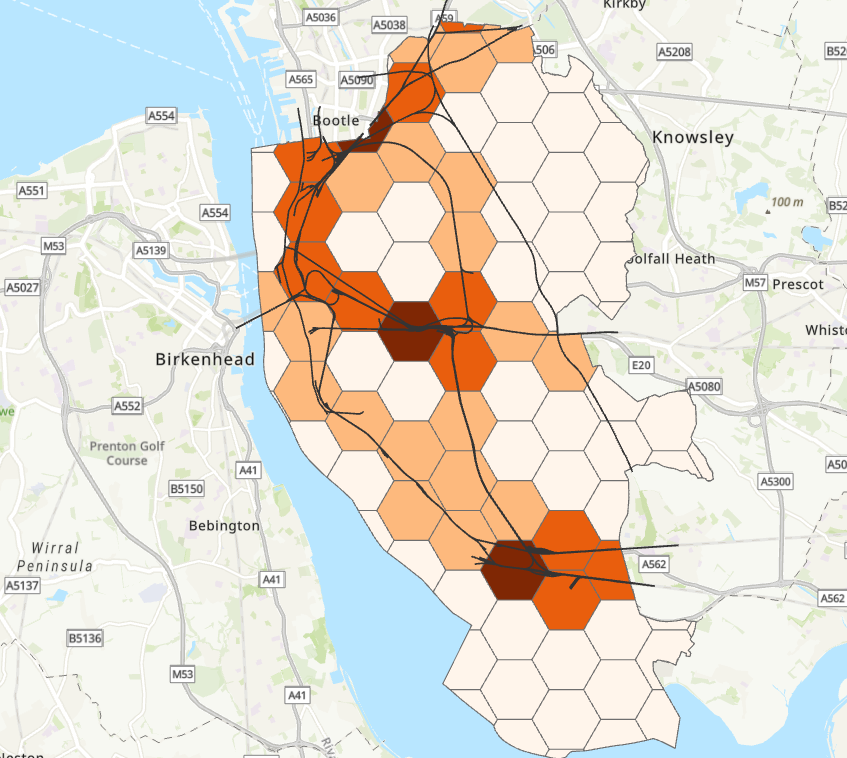